# TP 09 : Machine à vecteurs de support (SVM)


In [265]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib import colors
from util import preparer, generer_zeros_1
%matplotlib inline


## I- SVM Linéaire (LSVM)


### I-1- La prédiction 

Dans la régression logistique binaire, une classe est notée par $1$ et l'autre par $0$. 
Dans SVM, une classe est notée par $1$ et l'autre par $-1$.
Pour prédire le résultat, on utilise une fonction $signe$ sur la combinaison linéaire des attributs. 

$$signe(z) = \begin{cases}
1 & \text{si } z \ge 0 \\
0 & \text{sinon }
\end{cases}$$

In [266]:
def z_svm(X, Theta): 
    return np.dot(X, Theta)

# TODO réaliser cette fonction
def signe(z):
    S = np.empty((z.shape[0]))
    for i in range (z.shape[0]):
        if(z[i] < 0 ): S[i] = 0
        else: S[i] = 1
    return S

X_t = np.array([[2., -10.], [1., -2.], [1.5, 3.]])
Theta_t = np.array([0.5, 0.25])

z = z_svm(X_t, Theta_t)

#Résultat : (array([-1.5,  0. ,  1.5]), array([-1,  1,  1]))
z, signe(z)

(array([-1.5,  0. ,  1.5]), array([0., 1., 1.]))

### I-2- Fonction du coût


$$ J = \frac{1}{M} \left( \frac{1}{2} \sum\limits_{j=0}^{N} \theta_j^2 + C \sum\limits_{i=0}^{M} \max(0, 1- y^{(i)} z^{(i)}) \right)$$
Où :
- $M$ nombre des échantillons et $N$ nombre des attributs
- $(i)$ veut dire le ième échantillon
- $\theta_j$ est le paramètre de l'attribut $j$ (peu-être référencé par $w_j$ dans d'autres ouvrages)
- $z^{(i)} = \theta_0 + \sum_{j=1}^{N} \theta_j x_j^{(i)}$
- $C$ est un paramètre avec deux objectifs différents: maximiser la marge et minimiser le nombre d'erreurs sur les données d'entraînement. En modifiant le paramètre C, nous pouvons choisir de privilégier un objectif sur un autre.

In [267]:
# TODO compléter
def J_svm(Z, Y, Theta, C=1.):
    a = np.sum(Theta ** 2) / 2
    b = 0
    for i in range (Y.shape[0]):
        b += max(0,1 - Y[i] * Z[i])
    return (a + C * b) / Y.shape[0]

X_t = np.array([[2., -10.], [1., -2.], [1.5, 3.]])
Theta_t = np.array([0.5, 0.25])
Y_t = np.array([0., 1., 1.])

#Résultat : 0.71875
J_svm(z_svm(X_t, Theta_t), Y_t, Theta_t, C=1.)

0.71875

### I-3- Fonction des gradients


$$ \frac{\partial J}{\partial \theta_j} = 
\frac{1}{M} \sum\limits_{i=1}^M \begin{cases}
\theta_j & \text{si } y^{(i)} z^{(i)} \ge 1\\
\theta_j - C x^{(i)}_j y^{(i)} & \text{sinon}  \\
\end{cases}$$
Où :
- $M$ nombre des échantillons et $N$ nombre des attributs
- $(i)$ veut dire le ième échantillon
- $\theta_j$ est le paramètre de l'attribut $j$ (peu-être référencé par $w_j$ dans d'autres ouvrages)
- $z^{(i)} = \theta_0 + \sum_{j=1}^{N} \theta_j x_j^{(i)}$
- $C$ est un paramètre

In [268]:
def gradient_svm(X, Z, Y, Theta, C=1.):
    Thetas = np.array([Theta] * len(Y))
    Ys = np.array([Y] * len(Theta)).T
    Test = np.array([Y*Z >= 1] * len(Theta)).T
    return np.mean(np.where(Test, Thetas, Thetas - C * X * Ys), axis=0)


X_t = np.array([[2., -10.], [1., -2.], [1.5, 3.]])
Theta_t = np.array([0.5, 0.25])
Y_t = np.array([-1., 1., 1.])

# Résultat : array([0.16666667, 0.91666667])   
gradient_svm(X_t, z_svm(X_t, Theta_t), Y_t, Theta_t)

array([0.16666667, 0.91666667])

### I-4- Descente des gradients et regroupement des fonctions

Ici, en plus de la déscente des gradients (GD), on va introduire une autre méthode : Déscente stochastique des gradients (SGD). 

Dans cette méthode, la mise à jours des paramètres se fait pour chaque échantillon. 

In [269]:
# Déscente des gradients
def GD_svm(X, Y, norm=True, const=True, nbr_iter=100, alpha=0.1, C=1.): 

    X_pre, mean, std = preparer(X, norm, const)
    Theta = generer_zeros_1(X_pre.shape[1])
    
    couts = []
    
    for i in range(nbr_iter):
        Z = z_svm(X_pre, Theta)
        Theta -= alpha * gradient_svm(X_pre, Z, Y, Theta, C=C)
        couts.append(J_svm(Z, Y, Theta, C=C))
    
    return Theta, mean, std, couts

# Déscente stochastique des gradients (toutes les échantillons)
def SGD_svm(X, Y, norm=True, const=True, nbr_iter=100, alpha=0.1, C=1.): 

    X_pre, mean, std = preparer(X, norm, const)
    Theta = generer_zeros_1(X_pre.shape[1])
    
    couts = []
    
    for i in range(nbr_iter):
        np.random.shuffle(X_pre)
        for j in range(len(X_pre)): 
            X_1 = np.array([X_pre[j, :]])
            Y_1 = np.array([Y[j]])
            Z_1 = z_svm(X_1, Theta)
            Theta -= alpha * gradient_svm(X_1, Z_1, Y_1, Theta, C=C)
        Z = z_svm(X_pre, Theta)
        couts.append(J_svm(Z, Y, Theta, C=C))
    
    return Theta, mean, std, couts

import random

# Déscente stochastique des gradients (un échantillon par itération)
def SGD1_svm(X, Y, norm=True, const=True, nbr_iter=100, alpha=0.1, C=1.): 

    X_pre, mean, std = preparer(X, norm, const)
    Theta = generer_zeros_1(X_pre.shape[1])
    M = len(X_pre)
    
    couts = []
    
    for i in range(nbr_iter):
        # Mettre à jours les paramettres sur un seul échantillon
        j = random.randint(0, M-1) 
        X_1 = np.array([X_pre[j, :]])
        Y_1 = np.array([Y[j]])
        Z_1 = z_svm(X_1, Theta)
        Theta -= alpha * gradient_svm(X_1, Z_1, Y_1, Theta, C=C)
        #calculer le coût pour tous les échantillons
        Z = z_svm(X_pre, Theta)
        couts.append(J_svm(Z, Y, Theta, C=C))
    
    return Theta, mean, std, couts

X_t = np.array([[2., -10.], [1., -2.], [1.5, 3.]])
Y_t = np.array([-1., 1., 1.])

Theta, mean, std, couts = GD_svm(X_t, Y_t, C=10.)
Theta1, mean1, std1, couts1 = SGD_svm(X_t, Y_t, C=10.)
Theta2, mean2, std2, couts2 = SGD1_svm(X_t, Y_t, C=10.)
Theta, Theta1, Theta2

(array([ 0.62202845, -0.77185143,  0.91636254]),
 array([-0.06074323, -1.22321752,  1.19646114]),
 array([ 0.32761625, -0.79553716,  0.47098542]))

In [270]:
class SVM(object):
    
    def __init__(self, nbr_iter=100, alpha=0.1, norm=True, const=True, C=1., solver="GD"): 
        self.nbr_iter = nbr_iter
        self.alpha = alpha
        self.norm = norm
        self.const = const
        self.C = C
        if solver == "SGD":
            self.entrainer_svm = SGD_svm
        elif solver == "SGD1":
            self.entrainer_svm = SGD1_svm
        else:
            self.entrainer_svm = GD_svm
                
    
    def entrainer(self, X, Y): 
        YY = np.array(Y)
        #Transformer les Y == 0 vers Y == -1
        YY[YY==0] = -1
        #Choisir la fonction d'optimisation 
        
            
        self.Theta, self.mean, self.std, self.couts = self.entrainer_svm(X, YY, 
                                                                  nbr_iter=self.nbr_iter, 
                                                                  alpha=self.alpha,  
                                                                  norm=self.norm, 
                                                                  const=self.const,
                                                                  C = self.C)
        
    # La prédiction
    # si prob=True elle rend un vecteur de probabilités
    # sinon elle rend une vecteur de 1 et 0
    def predire(self, X): 
        X_pre, mean, std = preparer(X, self.norm, self.const, mean=self.mean, std=self.std)
        return signe(z_svm(X_pre, Theta))

    
X_t = np.array([[2., -10.], [1., -2.], [1.5, 3.]])
Y_t = np.array([0, 1, 1])
svm_t = SVM()
svm_t.entrainer(X_t, Y_t)
svm_t.predire(np.array([[2., 6.]]))

array([1.])

### I-4- Application sur des classes linéairement séparables

On va utiliser des notes générées automatiquement (le code est dans le dossier datasets)

**Analyser les résultats**

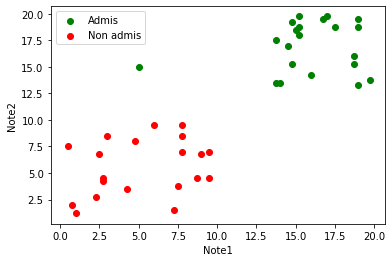

In [271]:
notes = pd.read_csv("datasets/notes.csv")
X_notes = notes.iloc[:, :-1].values # Premières colonnes 

r = notes["Admis"] == 1

Y_notes = notes.iloc[:,-1].values # Dernière colonne 
plt.scatter(X_notes[r, 0], X_notes[r, 1], color="green", label="Admis")

plt.scatter(X_notes[~r, 0], X_notes[~r, 1], color="red", label="Non admis")

plt.xlabel("Note1")
plt.ylabel("Note2")
plt.legend()
plt.show()

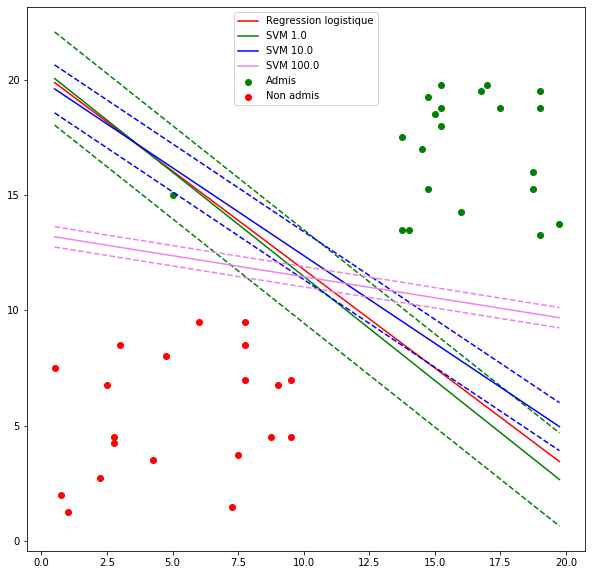

In [272]:
NBR_IT = 100
ALPHA = 0.1
Cs = [1., 10., 100.]
colors = ["green", "blue", "violet"]
from reg import RegLogistique
from util import ligne_decision


def dessigner(modele, ax, xx, color="r", sep=False, label=""):

    theta0 = modele.Theta[0]
    theta1 = modele.Theta[1]
    theta2 = modele.Theta[2]
    mean = modele.mean
    std = modele.std
    
    a = -theta1 / theta2
    yy = mean[1] - std[1] * (theta0 + theta1 * (xx - mean[0])/std[0]) / theta2
    ax.plot(xx, yy, 'k-', color=color, label=label)
    
    if sep:
        a = -theta1 / theta2
        margin = 1 / np.sqrt(theta1 ** 2 + theta2 ** 2)
        yy_down = yy - np.sqrt(1 + a ** 2) * margin
        yy_up = yy + np.sqrt(1 + a ** 2) * margin
        plt.plot(xx, yy_down, 'k--', color=color)
        plt.plot(xx, yy_up, 'k--', color=color)

fig, ax = plt.subplots(figsize=(10,10))

xx = np.linspace(X_notes[:,0].min(), X_notes[:,0].max(), 100)

ax.scatter(X_notes[r, 0], X_notes[r, 1], color="green", label="Admis")

ax.scatter(X_notes[~r, 0], X_notes[~r, 1], color="red", label="Non admis")

reglog = RegLogistique(nbr_iter=NBR_IT, alpha=ALPHA)
reglog.entrainer(X_notes, Y_notes)

dessigner(reglog, ax, xx, color="red", label="Regression logistique")


for i, C in enumerate(Cs):
    svm = SVM(nbr_iter=NBR_IT, alpha=ALPHA, C=C)
    svm.entrainer(X_notes, Y_notes)
    dessigner(svm, ax, xx, color=colors[i], sep=True, label="SVM " + str(C))

ax.legend()


**ANALYSE DES RESULTATS**
- On remarque que les données sont linéairement séparables donc les deux modèles SVM et la régression linéaire parviennent facilement à séparer les deux classes.
- On remarque que le SVM avec une interaction à une marge maximale supérieure à celle de 10 itérations qui a également une marge maximale supérieure à celle de 100 itérations.

### I-7- Comparison entre les méthodes d'optimisation

On veut comparer entre GD et SGD en terme de convergence des coûts et de temps d'entraînement. 
Pour ce faire, on compare entre ces méthodes : 
- GD : La descente des gradients 
- SGD : La descente stochastique des gradients (avec prise en charge de tous les échantillons)
- SGD1 : La descente stochastique des gradients (avec prise en charge d'un seul échantillon par itération)

**Analyser les résultats**

In [273]:
import timeit

NBR_IT = 100
ALPHA = 0.1
C = 10.
svm_gd = SVM(nbr_iter=NBR_IT, alpha=ALPHA, C=C)
temps_debut = timeit.default_timer()
svm_gd.entrainer(X_notes, Y_notes)
temps_gd = timeit.default_timer() - temps_debut

svm_sgd = SVM(nbr_iter=NBR_IT, alpha=ALPHA, C=C, solver="SGD")
temps_debut = timeit.default_timer()
svm_sgd.entrainer(X_notes, Y_notes)
temps_sgd = timeit.default_timer() - temps_debut

svm_sgd1 = SVM(nbr_iter=NBR_IT, alpha=ALPHA, C=C, solver="SGD1")
temps_debut = timeit.default_timer()
svm_sgd1.entrainer(X_notes, Y_notes)
temps_sgd1 = timeit.default_timer() - temps_debut

print("temps d'entrainement (GD vs. SGD vs. SGD1)")
temps_gd, temps_sgd, temps_sgd1

temps d'entrainement (GD vs. SGD vs. SGD1)


(0.02014199999939592, 0.12908410000000003, 0.016166599999451137)

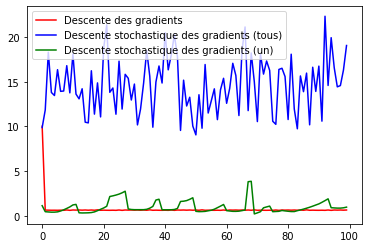

In [274]:
# Convergence des couts 
plt.plot(svm_gd.couts, color="red", label="Descente des gradients")
plt.plot(svm_sgd.couts, color="blue", label="Descente stochastique des gradients (tous)")
plt.plot(svm_sgd1.couts, color="green", label="Descente stochastique des gradients (un)")
plt.legend()
plt.show()

**ANALYSE DES RESULTATS**

Dans cette partie on va comparer entre GD et SGD en terme de convergence des coûts et de temps d'entraînement
- On remarque que SGD la descente stochastique des gradients (avec prise en charge de tous les échantillons) prend beaucoup de temps, tandis que la descente stochastique des gradients est venue réduire le temps d'entrainement qui est déjà grand avec la descente des gradients classiques quand on a un grand nombre de données d'entraînement.ce qui le cas pour SGD1 la descente stochastique des gradients (avec prise en charge d'un seul échantillon par itération) qui a le meilleur temps d'entrainement.


### I-6- Application sur des classes non linéairement séparables

On va utiliser des notes générées automatiquement (le code est dans le dossier datasets)

**Analyser les résultats**

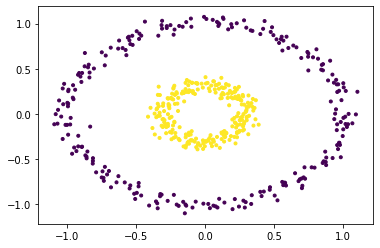

In [275]:
from sklearn.datasets import make_circles 
  
# generating data 
X_nl, Y_nl = make_circles(n_samples = 500, noise = 0.05, factor=0.3) 
  
# visualizing data 
plt.scatter(X_nl[:, 0], X_nl[:, 1], c = Y_nl, marker = '.') 
plt.show()

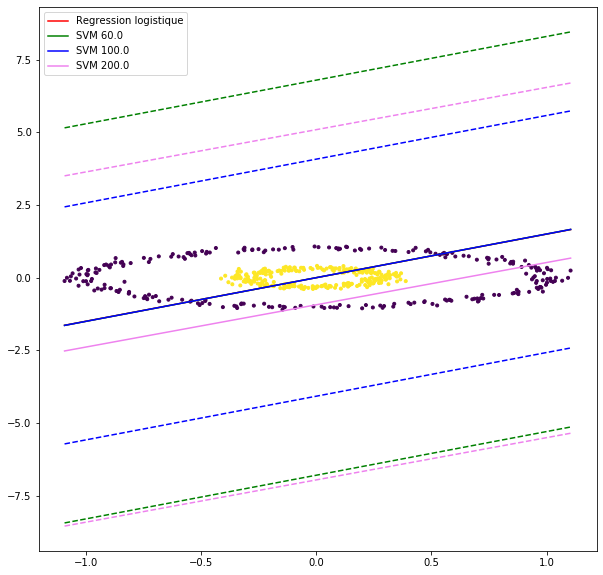

In [276]:
NBR_IT_nl = 100
ALPHA_nl = 0.1
Cs_nl = [60., 100., 200.]
colors_nl = ["green", "blue", "violet"]
from reg import RegLogistique
from util import ligne_decision


fig, ax = plt.subplots(figsize=(10,10))

xx_nl = np.linspace(X_nl[:,0].min(), X_nl[:,0].max(), 100)

ax.scatter(X_nl[:, 0], X_nl[:, 1], c = Y_nl, marker = '.') 

reglog_nl = RegLogistique(nbr_iter=NBR_IT_nl, alpha=ALPHA_nl)
reglog_nl.entrainer(X_nl, Y_nl)

dessigner(reglog_nl, ax, xx_nl, color="red", label="Regression logistique")


for i, C in enumerate(Cs_nl):
    svm = SVM(nbr_iter=NBR_IT_nl, alpha=ALPHA_nl, C=C)
    svm.entrainer(X_nl, Y_nl)
    dessigner(svm, ax, xx_nl, color=colors_nl[i], sep=True, label="SVM " + str(C))

ax.legend()

**ANALYSE**
- On remarque que les deux modèles SVM sans noyau et régression logistique sont incapables de séparer les deux classes car les classes ne sont pas linéairement séparables.

## II- SVM non Linéaire

Notre fonction de prédiction est formalisée comme : 
$$ f(X) = \sum\limits_{i=1}^{M} \theta X^{(i)} + \theta_0$$

On peut formaliser $\theta$ comme ([Hilary, A. Zisserman (2015), Lecture 3: SVM dual, kernels and regression](http://www.robots.ox.ac.uk/~az/lectures/ml/lect3.pdf)) : 
$$ \theta = \sum\limits_{i=1}^{M} \alpha_i X^{(i)} Y^{(i)}$$

La formation duale du problème sera : 
$$\max\limits_{\alpha_i \ge 0} \sum\limits_{i=1}^{M} \alpha_i - \frac{1}{2} \sum\limits_{i=1}^{M} \sum\limits_{j=1}^{M} \alpha_i \alpha_j y^{(i)} y^{(j)} x^{(i)} x^{(j)}$$
sous les contraintes : 
$$0 \le \alpha_i \le C$$
$$\sum\limits_{i=1}^{M} \alpha_i y^{(i)} = 0$$

### II-1- Noyau 

**Rien à programmer ou analyser ici**

On note $K(x^{(i)}, x^{(j)}) = x^{(i)} x^{(j)}$ et on l'appele un noyau linéaire.

L'idée du noyau est de chercher une séparation linéaire du problème dans un espace de dimension supérieure.
Ceci par l'application d'une fonction non linéaire sur les vecteurs d'entrée $X$.

Noyau gaussien (RBF kernel) :
$$K(x_1, x_2) = exp{(-\frac{||x_1 - x_2||^2}{2 \sigma^2})} = exp{(-\frac{\sum_i (x_1^{(i)} - x_2^{(i)})^2}{2 \sigma^2})}$$

In [277]:
def kernel_lineaire(X1, X2):
    return np.dot(X1, X2.T)

def kernel_gaussien(X1, X2, sigma=1):
    # Le cas de calcul du kernel entre deux échantillons (entraînement)
    # résultat: un scalar
    if np.ndim(X1) == 1 and np.ndim(X2) == 1:
        result = np.exp(- (np.linalg.norm(X1 - X2, 2)) ** 2 / (2 * sigma ** 2))
    # Le cas de calcul du kernel 
    elif (np.ndim(X1) > 1 and np.ndim(X2) == 1) or (np.ndim(X1) == 1 and np.ndim(X2) > 1):
        result = np.exp(- (np.linalg.norm(X1 - X2, 2, axis=1) ** 2) / (2 * sigma ** 2))
    elif np.ndim(X1) > 1 and np.ndim(X2) > 1:
        result = np.exp(- (np.linalg.norm(X1[:, np.newaxis] - X2[np.newaxis, :], 2, axis=2) ** 2) / (2 * sigma ** 2))
    return result


### II-2- Fonction objectif

$$W(\alpha) = \sum\limits_{i=1}^{M} \alpha_i - \frac{1}{2} \sum\limits_{i=1}^{M} \sum\limits_{j=1}^{M} \alpha_i \alpha_j y^{(i)} y^{(j)} K(x^{(i)}, x^{(j)})$$

In [278]:
# TODO implémenter
def f_objectif(X, Y, alphas, K):
    r1 = np.sum(alphas)
    r2 = alphas * Y 
    return r1 - np.sum(r2[:,None] * r2[None,:] * K(X,X)) / 2

a_t = np.array([1., .5, .25])
X_t = np.array([[1., 2.], [2., 3.], [2., 1.]])
Y_t = np.array([1, -1, 1])

# Résultat : 1.2026367706974372
f_objectif(X_t, Y_t, a_t, kernel_gaussien)

1.2026367706974372

### II-3- Fonction de décision 

$$\hat{y_t} = f(x_t) = \sum^M_{i=1} \alpha_i y^{(i)} K(x^{(i)}, x_t) - b$$
Où, 
- $x$ : les échantillons d'entraînement
- $x_t$ : les échantillons de test

In [279]:
# TODO implémenter
def f_decision(X_test, X_train, Y_train, alphas, b, K):
    resultF = (alphas * Y_train).dot(K(X_train,X_test))
    resultF -= b
    return resultF

a_t = np.array([1., .5, .25])
X_t = np.array([[1., 2.], [2., 3.], [2., 1.]])
Y_t = np.array([1, -1, 1])
X_tt = np.array([[1., 1.], [2., 2.]])

#Résultat : array([-0.28287917, -0.54510201])
f_decision(X_tt, X_t, Y_t, a_t, 1., kernel_gaussien)

array([-0.28287917, -0.54510201])

### II-4- Sequential minimal optimization

**Rien à programmer ou analyser ici**

Pour maximiser la fonction objectif, on va utiliser la méthode [Sequential minimal optimization)(https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf)

Ce code est une adaptation de [Implementing a Support Vector Machine using Sequential Minimal Optimization and Python 3.5](https://jonchar.net/notebooks/SVM/#Sequential-minimal-optimization)

In [280]:
def executer_etape(X, Y, alphas, b, erreurs, K, C, i1, i2, tol, eps):
    
    # Si les alphas choisis sont les mêmes, sortir
    if i1 == i2:
        return False, b
    
    alpha1 = alphas[i1]
    alpha2 = alphas[i2]
    y1 = Y[i1]
    y2 = Y[i2]
    E1 = erreurs[i1]
    E2 = erreurs[i2]
    s = y1 * y2
    
    # Compute L & H, the bounds on new possible alpha values
    if (y1 != y2):
        L = max(0, alpha2 - alpha1)
        H = min(C, C + alpha2 - alpha1)
    else:
        L = max(0, alpha1 + alpha2 - C)
        H = min(C, alpha1 + alpha2)
        
    if (L == H):
        return False, b

    # Compute kernel & 2nd derivative eta
    k11 = K(X[i1], X[i1])
    k12 = K(X[i1], X[i2])
    k22 = K(X[i2], X[i2])
    eta = 2 * k12 - k11 - k22
    
    # Compute new alpha 2 (a2) if eta is negative
    if (eta < 0):
        a2 = alpha2 - y2 * (E1 - E2) / eta
        # Clip a2 based on bounds L & H
        if a2 < L:
            a2 = L
        elif a2 > H:
            a2 = H
            
    # If eta is non-negative, move new a2 to bound with greater objective function value
    else:
        alphas_adj = alphas.copy()
        alphas_adj[i2] = L
        # objective function output with a2 = L
        Lobj = f_objectif(X, Y, alphas_adj, K) 
        alphas_adj[i2] = H
        # objective function output with a2 = H
        Hobj = f_objectif(X, Y, alphas_adj, K)
        if Lobj > (Hobj + eps):
            a2 = L
        elif Lobj < (Hobj - eps):
            a2 = H
        else:
            a2 = alpha2
            
    # Push a2 to 0 or C if very close
    if a2 < 1e-8:
        a2 = 0.0
    elif a2 > (C - 1e-8):
        a2 = C
    
    # If examples can't be optimized within epsilon (eps), skip this pair
    if np.abs(a2 - alpha2) < eps * (a2 + alpha2 + eps):
        return False, b
    
    # Calculate new alpha 1 (a1)
    a1 = alpha1 + s * (alpha2 - a2)
    
    # Update threshold b to reflect newly calculated alphas
    # Calculate both possible thresholds
    b1 = E1 + y1 * (a1 - alpha1) * k11 + y2 * (a2 - alpha2) * k12 + b
    b2 = E2 + y1 * (a1 - alpha1) * k12 + y2 * (a2 - alpha2) * k22 + b
    
    # Set new threshold based on if a1 or a2 is bound by L and/or H
    if 0 < a1 < C:
        b_new = b1
    elif 0 < a2 < C:
        b_new = b2
    # Average thresholds if both are bound
    else:
        b_new = (b1 + b2)/2.

    # Update model object with new alphas & threshold
    alphas[i1] = a1
    alphas[i2] = a2
    
    # Update error cache
    # Error cache for optimized alphas is set to 0 if they're unbound
    for index, alph in zip([i1, i2], [a1, a2]):
        if 0.0 < alph < C:
            erreurs[index] = 0.0
    
    # Set non-optimized errors based on equation 12.11 in Platt's book
    non_opt = [n for n in range(len(X)) if (n != i1 and n != i2)]
    erreurs[non_opt] += y1 * (a1 - alpha1) * K(X[i1], X[non_opt])
    erreurs[non_opt] += y2 * (a2 - alpha2) * K(X[i2], X[non_opt])
    erreurs[non_opt] += b - b_new
    
    return True, b_new

In [281]:
def examiner_exemple(X, Y, alphas, b, erreurs, K, C, i2, tol, eps):
    M = len(X)
    y2 = Y[i2]
    alpha2 = alphas[i2]
    E2 = erreurs[i2]
    r2 = E2 * y2

    # Proceed if error is within specified tolerance (tol)
    if ((r2 < -tol and alpha2 < C) or (r2 > tol and alpha2 > 0)):
        indices_examiner2 = np.where((alphas != 0) & (alphas != C))[0]
        M2 = len(indices_examiner2)
        if M2 > 1:
            # Use 2nd choice heuristic is choose max difference in error
            if erreurs[i2] > 0:
                i1 = np.argmin(erreurs)
            else:
                i1 = np.argmax(erreurs)
                
            step_result, b = executer_etape(X, Y, alphas, b, erreurs, K, C, i1, i2, tol, eps)
            if step_result:
                return True, b
            
            # Loop through non-zero and non-C alphas, starting at a random point
            for i1 in np.roll(indices_examiner2, np.random.choice(np.arange(M2))):
                step_result, b = executer_etape(X, Y, alphas, b, erreurs, K, C, i1, i2, tol, eps)
                if step_result:
                    return True, b
        
        # loop through all alphas, starting at a random point
        for i1 in np.roll(np.arange(M), np.random.choice(np.arange(M))):
            step_result, b = executer_etape(X, Y, alphas, b, erreurs, K, C, i1, i2, tol, eps)
            if step_result:
                return True, b
    
    return False, b

In [282]:
def ksvm_entrainer(X, Y, K, C=10., tol = 0.01, eps = 0.01):
    X_pre, mean, std = preparer(X, norm=True, const=False)
    M = len(X_pre)
    alphas = np.zeros(M)
    b = 0.0
    numChanged = 0
    examineAll = True
    objs = []
    erreurs = f_decision(X, X, Y, alphas, b, K) - Y
    
    while numChanged > 0 or examineAll:
        numChanged = 0
        if examineAll :
            indices_examiner = range(M)
        else: 
            indices_examiner = np.where((alphas != 0) & (alphas != C))[0]
        
        for i2 in indices_examiner:
            examine_result, b = examiner_exemple(X, Y, alphas, b, erreurs, K, C, i2, tol, eps)
            if examine_result:
                numChanged += 1
                objs.append(f_objectif(X, Y, alphas, K))
                    
        if examineAll == True:
            examineAll = False
        elif numChanged == 0:
            examineAll = True
        
    return alphas, b, objs


### II-5- Regrouper les fonctions

**Rien à programmer ou analyser ici**

In [283]:
class KSVM(object):
    def __init__(self, K=kernel_lineaire, C=10., tol = 0.01, eps = 0.01):
        self.C = C      # regularization parameter
        self.K = K     # kernel function
        self.tol = tol #tolérence des erreurs
        self.eps = eps #tolérence des alphas
    
    def entrainer(self, X, Y):
        self.X = X
        self.Y = Y
        self.alphas, self.b, self.objs = ksvm_entrainer(X, Y, self.K, self.C, tol = self.tol, eps = self.eps)
    
    def predire(self, X): 
        return f_decision(X, self.X, self.Y, self.alphas, self.b, self.K)
    
    def dessiner2D(self, ax, resolution=100, colors=('b', 'k', 'r'), levels=(-1, 0, 1)):
        # Generate coordinate grid of shape [resolution x resolution]
        # and evaluate the model over the entire space
        xrange = np.linspace(self.X[:,0].min(), self.X[:,0].max(), resolution)
        yrange = np.linspace(self.X[:,1].min(), self.X[:,1].max(), resolution)
        grid = [[self.predire(np.array([xr, yr])) for xr in xrange] for yr in yrange]
        grid = np.array(grid).reshape(len(xrange), len(yrange))
        
        # Plot decision contours using grid and
        # make a scatter plot of training data
        ax.contour(xrange, yrange, grid, levels=levels, linewidths=(1, 1, 1),
                   linestyles=('--', '-', '--'), colors=colors)
        ax.scatter(self.X[:,0], self.X[:,1],
                   c=self.Y, cmap=plt.cm.viridis, lw=0, alpha=0.25)
        
        # Plot support vectors (non-zero alphas)
        # as circled points (linewidth > 0)
        mask = np.round(self.alphas, decimals=2) != 0.0
        ax.scatter(self.X[mask,0], self.X[mask,1],
                   c=self.Y[mask], cmap=plt.cm.viridis, lw=1, edgecolors='k')
        
        return grid, ax

### II-6- Application du kernel RBF sur des classes non linéairement séparables

**Que remarquez-vous concernant la ligne de décision ?**
- On remarque que la ligne de décision ne prend pas la forme d'une ligne,elle prend la forme d'un cercle parfaitement centré entre les deux classes,car elle s'est adapté à la forme des données en utilisant SVM avec noyau.


**Que remarquez-vous concernant le nombre des itérations ?**
- On consatate que le modele a besoin d'un grand nombre d'iteration pour arriver a la convergence (200 iterations).

**A votre avis, pourquoi l'algorithme n'a pas arrêté lorsque la fonction objectif a atteint le maximum ?** (ça dépond le dataset généré, ce cas peut ne pas se produire. Mais, la question est dans le cas général)

PS. l'entraînement prend du temps

- l'algorithme n'a pas été arrêté lorsque  la fonction objectif a atteint le maximum car la condition d'arret ne s'agit pas selement de voir l'amelioration de la fonction mais aussi on doit tester et examiner tous le dataset.

fin entrainement; plotting ...


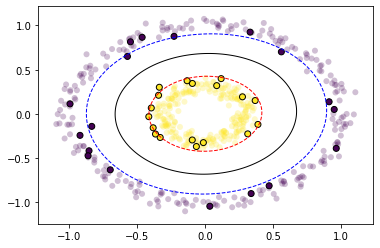

In [284]:
Y_nl2 = Y_nl.copy()

Y_nl2[Y_nl2 == 0] = -1

ksvm = KSVM(C=1.0, K=kernel_gaussien)

ksvm.entrainer(X_nl, Y_nl2)
print("fin entrainement; plotting ...")
fig, ax = plt.subplots()
grid, ax = ksvm.dessiner2D(ax)

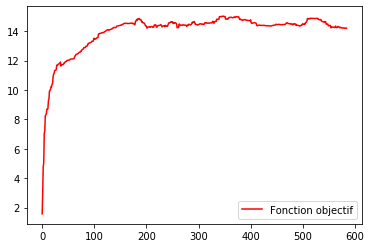

In [285]:
# La fonction objectif (à maximiser)
plt.plot(ksvm.objs, color="red", label="Fonction objectif")
plt.legend()
plt.show()